# Implementação do método PrOPPAGA para seleção de ações do Ibovespa

A metodologia Prioridade Observada a Partir da Presunção de Atitude Gaussiana das Alternativas (PrOPPAGA),foi desenvolvida com o objetivo de oferecer uma ferramenta simples para estruturar decisões que envolvem múltiplos critérios.

https://www.proppaga.com.br/

In [1]:
# Bibliotecas Utilizadas
import pandas as pd # Tratamento da base de dados
import matplotlib.pyplot as plt # Visualização dos dados
import seaborn as sns # Visualização dos dados
import numpy as np
import scipy.stats as stats
from datetime import datetime


# Web scraping https://selenium-python.readthedocs.io/index.html
from selenium import webdriver
from selenium.webdriver.common.by import By

### Tratamento base de dados Ibovespa

In [2]:
# Base de dados de empresas que compõem o ibovespa
# Data de extração: 29/12/2024
# Disponível em: https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-composicao-da-carteira.htm

data_ibov = pd.read_csv('data/IBOVDia_30-12-24.csv', sep=';')
data_ibov.head()

,Código,Ação,Tipo,Qtde. Teórica,Part. (%),Unnamed: 5
0,ALOS3,ALLOS,ON EJ NM,502.481.592,"0,470",NaN
1,ALPA4,ALPARGATAS,PN N1,166.460.180,"0,054",NaN
2,ABEV3,AMBEV S/A,ON EDJ,4.394.835.131,"2,728",NaN
3,ASAI3,ASSAI,ON NM,1.349.687.675,"0,398",NaN
4,AURE3,AUREN,ON NM,291.727.616,"0,131",NaN


In [3]:
# Total de empresas que compõem o índice
data_ibov.shape

(87, 6)

In [4]:
# Removendo colunas que não serão utilizadas
data_ibov_clean = data_ibov.drop(columns=data_ibov.columns[[3,4,5]])
data_ibov_clean

,Código,Ação,Tipo
0,ALOS3,ALLOS,ON EJ NM
1,ALPA4,ALPARGATAS,PN N1
2,ABEV3,AMBEV S/A,ON EDJ
3,ASAI3,ASSAI,ON NM
4,AURE3,AUREN,ON NM
...,...,...,...
82,VAMO3,VAMOS,ON NM
83,VBBR3,VIBRA,ON EJ NM
84,VIVA3,VIVARA S.A.,ON NM
85,WEGE3,WEG,ON EJ NM


In [5]:
# Salvando o arquivo para ser utilizado depois
data_ibov_clean.to_csv("data/lista_ibov.csv", index=False)

### Web Scraping Site Fundamentus

In [6]:
# Leitura da lista de ativos tratados
df = pd.read_csv('data/lista_ibov.csv')
df

,Código,Ação,Tipo
0,ALOS3,ALLOS,ON EJ NM
1,ALPA4,ALPARGATAS,PN N1
2,ABEV3,AMBEV S/A,ON EDJ
3,ASAI3,ASSAI,ON NM
4,AURE3,AUREN,ON NM
...,...,...,...
82,VAMO3,VAMOS,ON NM
83,VBBR3,VIBRA,ON EJ NM
84,VIVA3,VIVARA S.A.,ON NM
85,WEGE3,WEG,ON EJ NM


In [7]:
# Inicializa as variáveis que serão extraidas da web
df['setor'] = None
df['LPA'] = None
df['ROA'] = None
df['ROE'] = None
df['P/L'] = None
df['VPA'] = None

In [8]:
df.head()

,Código,Ação,Tipo,setor,LPA,ROA,ROE,P/L,VPA
0,ALOS3,ALLOS,ON EJ NM,None,None,None,None,None,None
1,ALPA4,ALPARGATAS,PN N1,None,None,None,None,None,None
2,ABEV3,AMBEV S/A,ON EDJ,None,None,None,None,None,None
3,ASAI3,ASSAI,ON NM,None,None,None,None,None,None
4,AURE3,AUREN,ON NM,None,None,None,None,None,None


Obter do site https://www.fundamentus.com.br/ as informações para cada ativo.

In [9]:
from selenium import webdriver
from selenium.webdriver.common.by import By

# Inicializa o driver especificando o navegador de busca
driver = webdriver.Chrome()

total_lidos = 0
total_erros = 0

# Lista de códigos de ativos que precisam de tratamento especial pois a posição da informação
# está em um estado diferente da pagina do fundamentus
codigos_com_erro = ['BBDC3', 'BBDC4', 'BBAS3', 'BPAC11', 'ITUB4', 'SANB11', 'TIMS3']

for i in df['Código']:
    try:
        # Realiza a consulta no site para cada ativo
        driver.get(f'https://www.fundamentus.com.br/detalhes.php?papel={i}')
        
        # Obtem o valor dos campos para cada classe de busca especificando a posição do objeto
        setor = driver.find_elements(By.CLASS_NAME, 'txt')[13].text
        pl = driver.find_elements(By.CLASS_NAME, 'txt')[32].text
        lpa = driver.find_elements(By.CLASS_NAME, 'txt')[34].text
        vpa = driver.find_elements(By.CLASS_NAME, 'txt')[39].text
        roe = driver.find_elements(By.CLASS_NAME, 'txt')[69].text

        # Inicializa a variavel
        lucro_liquido = None

        # Lógica para pegar o lucro líquido dependendo do código do ativo
        if i in codigos_com_erro:
            lucro_liquido = driver.find_elements(By.CLASS_NAME, 'txt')[106].text
        else:
            lucro_liquido = driver.find_elements(By.CLASS_NAME, 'txt')[110].text
        
        # Converte o valor de lucro líquido em float
        lucro_liquido_float = float(lucro_liquido.replace('.', '').replace(',', '.'))

        # Obtém o valor do ativo e converte em float
        ativo = driver.find_elements(By.CLASS_NAME, 'txt')[87].text.replace('.', '')
        ativo_float = float(ativo)

        # Calcular o ROA (com verificação para divisão por zero)
        roa = None
        if ativo_float != 0.00 and lucro_liquido_float != 0.00:
            roa = round((lucro_liquido_float / ativo_float) * 100, 2)

        # Salva a informação coletada no seu respectivo campo
        df.loc[df['Código'] == i, 'setor'] = setor
        df.loc[df['Código'] == i, 'P/L'] = pl
        df.loc[df['Código'] == i, 'LPA'] = lpa
        df.loc[df['Código'] == i, 'VPA'] = vpa 

        # Existem ativos que não possuem o ROE na plataforma
        if roe != '-':
            df.loc[df['Código'] == i, 'ROE'] = roe
    
        df.loc[df['Código'] == i, 'ROA'] = roa

        total_lidos += 1

    except Exception as e:
        print(f'Erro ao obter os dados para o ativo {i}: {e}')
        total_erros += 1

# Encerra o driver de pesquisa após a extração dos dados
driver.quit()
print(f"total lidos = {total_lidos}")
print(f"total erros = {total_erros}")


total lidos = 87
total erros = 0


In [10]:
# Gera a base de dados com referencia ao dia que a função de scraping foi executada
now = datetime.now().strftime('%d-%m-%Y')
df.to_csv(f"dados_gerais_{now}.csv", index=False)

### Limpeza dos dados

In [6]:
df = pd.read_csv('data/dados_gerais_dezembro_2024.csv')

In [7]:
# Tipagem e limpeza dos dados coletados
df['ROA'] = df['ROA'].astype('float64')
df['VPA'] = df['VPA'].str.replace(',', '.').astype('float64')
df['P/L'] = df['P/L'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype('float64')
df['LPA'] = df['LPA'].str.replace(',', '.').astype('float64')
df['ROE'] = df['ROE'].str.replace('%', '')
df['ROE'] = df['ROE'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype('float64')

In [8]:
# Verifica se a base possui valores ausentes
df.isnull().sum()

Código    0
Ação      0
Tipo      0
setor     0
LPA       0
ROA       2
ROE       2
P/L       0
VPA       0
dtype: int64

In [9]:
# Identificação dos resgistros ausentes
df[df['ROE'].isnull()]

,Código,Ação,Tipo,setor,LPA,ROA,ROE,P/L,VPA
5,AMOB3,AUTOMOB,ON NM,Automóveis e Motocicletas,0.00,NaN,NaN,0.00,0.81
77,TIMS3,TIM,ON EJ NM,Telecomunicações,0.66,NaN,NaN,23.59,0.00


In [10]:
# Para a aplicação da metodologia, é nescessário que todos os registros possuam critérios válidos
# Na base de dados coletadas os ativos AMOB3 e TIMS3 não possuem dados válidos de ROA e ROE portanto
# os registros desses ativos serão desconsiderados da base de dados.
df.dropna(inplace=True)

### Estatísticas Descritivas

In [11]:
df.head()

,Código,Ação,Tipo,setor,LPA,ROA,ROE,P/L,VPA
0,ALOS3,ALLOS,ON EJ NM,Exploração de Imóveis,1.41,2.58,5.5,13.48,25.68
1,ALPA4,ALPARGATAS,PN N1,"Tecidos, Vestuário e Calçados",-2.20,-22.66,-37.9,-2.82,5.79
2,ABEV3,AMBEV S/A,ON EDJ,Bebidas,0.88,9.47,14.2,12.54,6.23
3,ASAI3,ASSAI,ON NM,Comércio e Distribuição,0.47,1.45,12.7,14.33,3.69
4,AURE3,AUREN,ON NM,Energia Elétrica,0.69,2.30,5.7,11.78,11.98


In [12]:
# Total de Setores
df['setor'].nunique()

27

In [13]:
total_by_setor = df.groupby('setor')['Código'].count().sort_values(ascending=True)

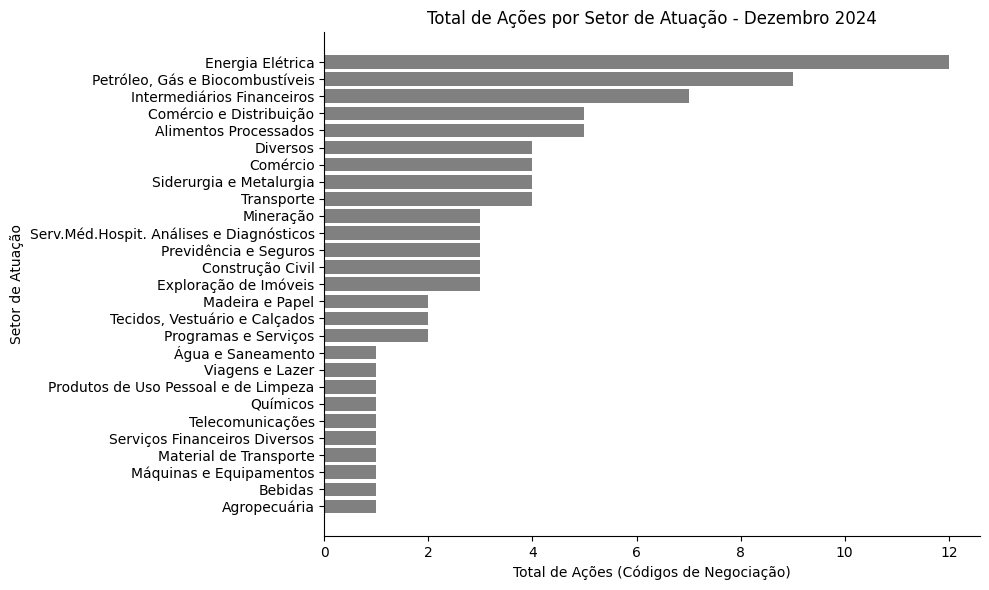

In [14]:
plt.figure(figsize=(10, 6))
plt.barh(total_by_setor.index, total_by_setor.values, color='gray')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Total de Ações por Setor de Atuação - Dezembro 2024')
plt.xlabel('Total de Ações (Códigos de Negociação)')
plt.ylabel('Setor de Atuação')
plt.tight_layout()

In [15]:
# Estatísticas univariadas
df.describe()

,LPA,ROA,ROE,P/L,VPA
count,85.000000,85.000000,85.000000,85.000000,85.000000
mean,1.770941,4.227412,375.378824,47.448588,15.422471
std,3.486103,9.105556,3354.995313,248.901597,16.382173
min,-13.650000,-34.470000,-71.800000,-49.020000,-74.790000
25%,0.650000,1.430000,5.700000,6.460000,6.690000
50%,1.490000,3.560000,12.700000,8.840000,11.980000
75%,3.300000,7.680000,19.900000,14.640000,22.120000
max,13.650000,44.320000,30942.600000,2218.290000,58.770000


In [17]:
# Separando os setores
df_energia = df[df['setor'] == 'Energia Elétrica']
df_intermediario = df[df['setor'] == 'Intermediários Financeiros']
df_petroleo = df[df['setor'] == 'Petróleo, Gás e Biocombustíveis']

### Aplicação da Metodologia ProPPAGA

In [18]:
# Função para calcular ProPPAGA
def calcular_proppaga(df):
    print('='*60, flush=True)
    print('INICIANDO CÁLCULO ProPPAGA', flush=True)
    print('='*60, flush=True)

    # Etapa 1: Atribuição dos pesos
    print('\n Atribuindo pesos aos critérios com base em Santos e Santos (2021)', flush=True)
    pl = 7
    roe = 6
    roa = 5
    lpa = 4
    vpa = 2

    somatorio_criterios = pl + roe + roa + lpa + vpa
    print(f'Pesos atribuídos:', flush=True)
    print(f'P/L: {pl} | ROE: {roe} | ROA: {roa} | LPA: {lpa} | VPA: {vpa}', flush=True)
    print(f'Somatório dos Pesos: {somatorio_criterios}', flush=True)

    # Etapa 2: Ajustar monotonicidade do P/L
    print('\n Ajustando monotonicidade do P/L (Critério de Custo)', flush=True)
    df['P/L'] = df['P/L'] * -1

    # Cálculo dos pesos normalizados
    peso_pl  = pl / somatorio_criterios
    peso_roe = roe / somatorio_criterios
    peso_roa = roa / somatorio_criterios
    peso_lpa = lpa / somatorio_criterios
    peso_vpa = vpa / somatorio_criterios

    print('Pesos Normalizados:', flush=True)
    print(f'P/L: {peso_pl:.4f} | ROE: {peso_roe:.4f} | ROA: {peso_roa:.4f} | LPA: {peso_lpa:.4f} | VPA: {peso_vpa:.4f}', flush=True)

    # Etapa 3: Média e Desvio Padrão
    print('\n Calculando Médias e Desvios Padrões', flush=True)

    medias = {}
    desvios = {}

    for coluna in ['P/L', 'ROE', 'ROA', 'LPA', 'VPA']:
        medias[coluna] = df[coluna].mean()
        desvios[coluna] = np.std(df[coluna])
        print(f'{coluna} --> Média: {medias[coluna]:.4f} | Desvio Padrão: {desvios[coluna]:.4f}', flush=True)

    # Etapa 4: Normalização
    print('\n Aplicando Função de Distribuição Cumulativa (CDF) para Normalização', flush=True)

    for coluna in ['P/L', 'ROE', 'ROA', 'LPA', 'VPA']:
        df[coluna] = stats.norm.cdf(df[coluna], loc=medias[coluna], scale=desvios[coluna])
        print(f'{coluna} normalizado com CDF', flush=True)

    # Etapa 5: Cálculo da Cardinalidade
    print('\n Calculando Cardinalidade Final (ProPPAGA)', flush=True)

    df['Cardinalidade'] = (
        df['P/L'] * peso_pl +
        df['ROE'] * peso_roe +
        df['ROA'] * peso_roa +
        df['LPA'] * peso_lpa +
        df['VPA'] * peso_vpa
    )

    print('Cardinalidade calculada com sucesso!', flush=True)

    print('\n[FINALIZAÇÃO] - Resultado pronto!', flush=True)
    print('='*60, flush=True)
    print('Exibindo 5 primeiras linhas do dataframe resultante:', flush=True)
    print(df.head(), flush=True)

    return df


In [19]:
df_agregado = calcular_proppaga(df)

INICIANDO CÁLCULO ProPPAGA

 Atribuindo pesos aos critérios com base em Santos e Santos (2021)
Pesos atribuídos:
P/L: 7 | ROE: 6 | ROA: 5 | LPA: 4 | VPA: 2
Somatório dos Pesos: 24

 Ajustando monotonicidade do P/L (Critério de Custo)
Pesos Normalizados:
P/L: 0.2917 | ROE: 0.2500 | ROA: 0.2083 | LPA: 0.1667 | VPA: 0.0833

 Calculando Médias e Desvios Padrões
P/L --> Média: -47.4486 | Desvio Padrão: 247.4331
ROE --> Média: 375.3788 | Desvio Padrão: 3335.2017
ROA --> Média: 4.2274 | Desvio Padrão: 9.0518
LPA --> Média: 1.7709 | Desvio Padrão: 3.4655
VPA --> Média: 15.4225 | Desvio Padrão: 16.2855

 Aplicando Função de Distribuição Cumulativa (CDF) para Normalização
P/L normalizado com CDF
ROE normalizado com CDF
ROA normalizado com CDF
LPA normalizado com CDF
VPA normalizado com CDF

 Calculando Cardinalidade Final (ProPPAGA)
Cardinalidade calculada com sucesso!

[FINALIZAÇÃO] - Resultado pronto!
Exibindo 5 primeiras linhas do dataframe resultante:
  Código        Ação        Tipo        

In [20]:
df_agregado.sort_values(by='Cardinalidade', ascending=False)

,Código,Ação,Tipo,setor,LPA,ROA,ROE,P/L,VPA,Cardinalidade
68,SBSP3,SABESP,ON NM,Água e Saneamento,0.999696,0.812568,0.458119,5.650383e-01,9.930236e-01,0.697985
83,VBBR3,VIBRA,ON EJ NM,"Petróleo, Gás e Biocombustíveis",0.967798,0.951615,0.460522,5.727727e-01,5.689188e-01,0.689152
81,VALE3,VALE,ON NM,Mineração,0.994711,0.736733,0.457940,5.679477e-01,9.695706e-01,0.680205
12,BRAP4,BRADESPAR,PN EJ N1,Mineração,0.792022,0.961367,0.457631,5.702822e-01,6.660616e-01,0.668534
9,BBSE3,BBSEGURIDADE,ON NM,Previdência e Seguros,0.763693,0.999995,0.463463,5.616633e-01,2.841364e-01,0.638977
...,...,...,...,...,...,...,...,...,...,...
40,NTCO3,GRUPO NATURA,ON NM,Produtos de Uso Pessoal e de Limpeza,0.002320,0.000010,0.446670,5.785199e-01,3.977105e-01,0.313934
6,AZUL4,AZUL,PN N2,Transporte,0.000004,0.003368,0.457369,5.765743e-01,1.517310e-08,0.283212
63,PETZ3,PETZ,ON NM,Comércio,0.305681,0.325794,0.455229,7.554866e-02,2.352544e-01,0.274268
19,CRFB3,CARREFOUR BR,ON EJ NM,Comércio e Distribuição,0.305681,0.321428,0.455205,2.751078e-02,3.559926e-01,0.269402


### Aplicação no Setor de Energia

In [291]:
df = calcular_proppaga(df_energia)
df.sort_values(by='Cardinalidade', ascending=False)

INICIANDO CÁLCULO ProPPAGA

 Atribuindo pesos aos critérios com base em Santos e Santos (2021)
Pesos atribuídos:
P/L: 7 | ROE: 6 | ROA: 5 | LPA: 4 | VPA: 2
Somatório dos Pesos: 24

 Ajustando monotonicidade do P/L (Critério de Custo)
Pesos Normalizados:
P/L: 0.2917 | ROE: 0.2500 | ROA: 0.2083 | LPA: 0.1667 | VPA: 0.0833

 Calculando Médias e Desvios Padrões
P/L --> Média: -10.1883 | Desvio Padrão: 6.3807
ROE --> Média: 16.2750 | Desvio Padrão: 10.0271
ROA --> Média: 5.4925 | Desvio Padrão: 3.2010
LPA --> Média: 3.3308 | Desvio Padrão: 1.7973
VPA --> Média: 23.3608 | Desvio Padrão: 15.3343

 Aplicando Função de Distribuição Cumulativa (CDF) para Normalização
P/L normalizado com CDF
ROE normalizado com CDF
ROA normalizado com CDF
LPA normalizado com CDF
VPA normalizado com CDF

 Calculando Cardinalidade Final (ProPPAGA)
Cardinalidade calculada com sucesso!

[FINALIZAÇÃO] - Resultado pronto!
Exibindo 5 primeiras linhas do dataframe resultante:
   Código          Ação        Tipo          

C:\Users\amand\AppData\Local\Temp\ipykernel_28416\1578835668.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P/L'] = df['P/L'] * -1
C:\Users\amand\AppData\Local\Temp\ipykernel_28416\1578835668.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = stats.norm.cdf(df[coluna], loc=medias[coluna], scale=desvios[coluna])
C:\Users\amand\AppData\Local\Temp\ipykernel_28416\1578835668.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,Código,Ação,Tipo,setor,LPA,ROA,ROE,P/L,VPA,Cardinalidade
34,EGIE3,ENGIE BRASIL,ON EJ NM,Energia Elétrica,0.837530,0.835726,0.986671,0.679108,0.254413,0.779640
21,CMIG4,CEMIG,PN EJ N1,Energia Elétrica,0.383862,0.987828,0.888614,0.837047,0.188430,0.751769
45,ISAE4,ISA ENERGIA,PN N1,Energia Elétrica,0.826352,0.795906,0.520878,0.803414,0.666057,0.723592
25,CPFE3,CPFL ENERGIA,ON NM,Energia Elétrica,0.786747,0.710654,0.855342,0.679108,0.356490,0.720794
75,TAEE11,TAESA,UNT N2,Energia Elétrica,0.677725,0.692232,0.666886,0.630644,0.418345,0.642690
32,ENGI11,ENERGISA,UNT N2,Energia Elétrica,0.876332,0.252642,0.461269,0.672911,0.784571,0.575653
29,ELET3,ELETROBRAS,ON ED N1,Energia Elétrica,0.724039,0.280334,0.216119,0.622334,0.971556,0.495583
30,ELET6,ELETROBRAS,PNB ED N1,Energia Elétrica,0.724039,0.280334,0.216119,0.572642,0.971556,0.481089
23,CPLE6,COPEL,PNB N2,Energia Elétrica,0.101223,0.499688,0.342225,0.553505,0.167056,0.381889
4,AURE3,AUREN,ON NM,Energia Elétrica,0.070869,0.159298,0.145796,0.401506,0.228988,0.217636


### Aplicação no Setor de Intermediários Financeiros

In [304]:
df = calcular_proppaga(df_intermediario)

INICIANDO CÁLCULO ProPPAGA

 Atribuindo pesos aos critérios com base em Santos e Santos (2021)
Pesos atribuídos:
P/L: 7 | ROE: 6 | ROA: 5 | LPA: 4 | VPA: 2
Somatório dos Pesos: 24

 Ajustando monotonicidade do P/L (Critério de Custo)
Pesos Normalizados:
P/L: 0.2917 | ROE: 0.2500 | ROA: 0.2083 | LPA: 0.1667 | VPA: 0.0833

 Calculando Médias e Desvios Padrões
P/L --> Média: -7.9329 | Desvio Padrão: 1.7998
ROE --> Média: 15.4429 | Desvio Padrão: 4.2995
ROA --> Média: 3.9271 | Desvio Padrão: 4.3241
LPA --> Média: 2.9057 | Desvio Padrão: 1.6112
VPA --> Média: 18.2343 | Desvio Padrão: 6.8573

 Aplicando Função de Distribuição Cumulativa (CDF) para Normalização
P/L normalizado com CDF
ROE normalizado com CDF
ROA normalizado com CDF
LPA normalizado com CDF
VPA normalizado com CDF

 Calculando Cardinalidade Final (ProPPAGA)
Cardinalidade calculada com sucesso!

[FINALIZAÇÃO] - Resultado pronto!
Exibindo 5 primeiras linhas do dataframe resultante:
    Código        Ação        Tipo              

C:\Users\amand\AppData\Local\Temp\ipykernel_28416\1578835668.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P/L'] = df['P/L'] * -1
C:\Users\amand\AppData\Local\Temp\ipykernel_28416\1578835668.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = stats.norm.cdf(df[coluna], loc=medias[coluna], scale=desvios[coluna])
C:\Users\amand\AppData\Local\Temp\ipykernel_28416\1578835668.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [305]:
df.sort_values(by='Cardinalidade', ascending=False)

,Código,Ação,Tipo,setor,LPA,ROA,ROE,P/L,VPA,Cardinalidade
13,BBAS3,BRASIL,ON NM,Intermediários Financeiros,0.978620,0.283365,0.850057,0.972122,0.968673,0.798910
47,ITUB4,ITAUUNIBANCO,PN N1,Intermediários Financeiros,0.716907,0.853279,0.815174,0.307120,0.590305,0.639813
46,ITSA4,ITAUSA,PN N1,Intermediários Financeiros,0.157972,0.976933,0.569893,0.624869,0.067216,0.560184
17,BPAC11,BTGP BANCO,UNT EX N2,Intermediários Financeiros,0.515914,0.344789,0.865735,0.046289,0.301608,0.412885
69,SANB11,SANTANDER BR,UNT,Intermediários Financeiros,0.547991,0.241941,0.292904,0.404046,0.782178,0.397991
10,BBDC3,BRADESCO,ON N1,Intermediários Financeiros,0.189783,0.246295,0.090821,0.616411,0.334890,0.313341
11,BBDC4,BRADESCO,PN N1,Intermediários Financeiros,0.189783,0.246295,0.090821,0.460797,0.334890,0.267954


### Aplicação Setor de Petróleo

In [306]:
df_petroleo = calcular_proppaga(df_petroleo)
df_petroleo.sort_values(by='Cardinalidade', ascending=False)

INICIANDO CÁLCULO ProPPAGA

 Atribuindo pesos aos critérios com base em Santos e Santos (2021)
Pesos atribuídos:
P/L: 7 | ROE: 6 | ROA: 5 | LPA: 4 | VPA: 2
Somatório dos Pesos: 24

 Ajustando monotonicidade do P/L (Critério de Custo)
Pesos Normalizados:
P/L: 0.2917 | ROE: 0.2500 | ROA: 0.2083 | LPA: 0.1667 | VPA: 0.0833

 Calculando Médias e Desvios Padrões
P/L --> Média: -9.8544 | Desvio Padrão: 7.2309
ROE --> Média: 18.3000 | Desvio Padrão: 11.9408
ROA --> Média: 7.1278 | Desvio Padrão: 5.5121
LPA --> Média: 3.7267 | Desvio Padrão: 2.7978
VPA --> Média: 18.3778 | Desvio Padrão: 8.7747

 Aplicando Função de Distribuição Cumulativa (CDF) para Normalização
P/L normalizado com CDF
ROE normalizado com CDF
ROA normalizado com CDF
LPA normalizado com CDF
VPA normalizado com CDF

 Calculando Cardinalidade Final (ProPPAGA)
Cardinalidade calculada com sucesso!

[FINALIZAÇÃO] - Resultado pronto!
Exibindo 5 primeiras linhas do dataframe resultante:
   Código        Ação        Tipo              

,Código,Ação,Tipo,setor,LPA,ROA,ROE,P/L,VPA,Cardinalidade
83,VBBR3,VIBRA,ON EJ NM,"Petróleo, Gás e Biocombustíveis",0.944275,0.986133,0.986766,0.859469,0.494191,0.901376
62,PRIO3,PETRORIO,ON NM,"Petróleo, Gás e Biocombustíveis",0.733391,0.776537,0.764306,0.627640,0.586700,0.707040
60,PETR4,PETROBRAS,PN EDJ N2,"Petróleo, Gás e Biocombustíveis",0.845248,0.552840,0.605646,0.715325,0.917134,0.692526
59,PETR3,PETROBRAS,ON EDJ N2,"Petróleo, Gás e Biocombustíveis",0.845248,0.552840,0.605646,0.686528,0.917134,0.684126
79,UGPA3,ULTRAPAR,ON NM,"Petróleo, Gás e Biocombustíveis",0.311343,0.466185,0.483300,0.651445,0.276806,0.482909
61,RECV3,PETRORECSA,ON NM,"Petróleo, Gás e Biocombustíveis",0.270932,0.539901,0.325551,0.608127,0.375354,0.447672
24,CSAN3,COSAN,ON NM,"Petróleo, Gás e Biocombustíveis",0.183241,0.155356,0.276055,0.680621,0.189862,0.346256
15,BRAV3,BRAVA,ON NM,"Petróleo, Gás e Biocombustíveis",0.174830,0.150641,0.125623,0.077048,0.747595,0.176700
65,RAIZ4,RAIZEN,PN N2,"Petróleo, Gás e Biocombustíveis",0.095612,0.116014,0.107589,0.015137,0.031793,0.074067
